[Table of Contents](./table_of_contents.ipynb)

# Фильтр g-h

In [1]:
%matplotlib inline

In [35]:
#format the book
import book_format
book_format.set_style()

Прежде чем мы начнем, убедитесь, что вы понимаете, как использовать [Записные книжки Jupyter](http://jupyter.org/), и знакомы с [SciPy](https://scipy.org), [NumPy](http://www.numpy.org/) и [Matplotlib](https://matplotlib.org/) пакеты, как они используются на протяжении всей этой книги. В предисловии содержится введение в эти пакеты.

## Развитие интуиции с помощью мысленных экспериментов

Представьте, что мы живем в мире без весов - устройств, на которые вы встаете, чтобы взвеситься. Однажды на работе к вам подбегает коллега и объявляет вам о своем изобретении 'весов'. После того, как он объяснит, вы нетерпеливо встаете на них и объявляете результаты: "172 фунта". Вы в восторге - впервые в своей жизни вы знаете, сколько вы весите. Что еще более важно, знаки доллара пляшут у вас в глазах, когда вы представляете, как продаете это устройство клиникам по снижению веса по всему миру! Это фантастика!

Другой коллега слышит шум и подходит, чтобы узнать, что вас так взволновало. Вы рассказываете про изобретение, снова встаете на весы и с гордостью объявляете результат: "161 фунт". И тогда вы колеблетесь, сбиты с толку.

"Несколько секунд назад он показывал 172 фунта", - жалуетесь вы своему коллеге.

"Я никогда не говорила, что это точно", - отвечает она.

Датчики неточны. Это мотивация, стоящая за огромным объемом работы по фильтрации, и решение этой проблемы является темой этой книги. Я мог бы просто предложить решения, которые были разработаны за последние полвека, но эти решения были разработаны путем постановки очень простых, фундаментальных вопросов о природе того, что мы знаем и как мы это знаем. Прежде чем мы попытаемся вычислить, давайте проследим этот путь открытий и посмотрим, информирует ли это нашу интуицию о фильтрации.

**Попробуйте Другую Шкалу**

Есть ли какой-нибудь способ улучшить этот результат? Очевидно, что первое, что нужно попробовать, - это получить лучший датчик. К сожалению, ваша коллега сообщает вам, что она сделала 10 весов, и все они работают примерно с одинаковой точностью. Вы просите ее принести другие весы, и вы взвешиваетесь на одних, а затем на других. Первая шкала (А) показывает "160 фунтов", а вторая (Б) - "170 фунтов". Какой мы можем сделать вывод о вашем весе?

Итак, какой у нас выбор?

* Мы могли бы выбрать только весы А и присвоить 160 фунтов нашей оценке веса.
* Мы могли бы выбрать только весы В и приписать нашему весу 170 фунтов.
* Мы могли бы выбрать число, меньшее, чем A и B.
* Мы могли бы выбрать число, большее, чем A и B.
* Мы могли бы выбрать число между A и B.

Первые два варианта правдоподобны, но у нас нет причин отдавать предпочтение одной шкале перед другой. Почему мы решили верить А, а не В? У нас нет оснований для такого убеждения. Третий и четвертый варианты иррациональны. Шкалы, по общему признанию, не очень точны, но нет никаких причин выбирать число за пределами диапазона того, что они оба измерили. Последний выбор - единственно разумный. Если обе шкалы неточны и с такой же вероятностью дадут результат выше моего фактического веса, как и ниже его, чаще всего ответ находится где-то между A и B. 

В математике это понятие формализуется как [*ожидаемое значение*](https://en.wikipedia.org/wiki/Expected_value), и мы подробно рассмотрим это позже. А пока спросите себя, что было бы 'обычным', если бы мы сделали миллион показаний. Иногда обе шкалы будут показывать слишком низкие значения, иногда обе будут показывать слишком высокие значения, а в остальное время они будут колебаться между фактическим весом. Если они соответствуют фактическому весу, то, конечно, мы должны выбрать число между A и B. Если они не совпадают, то мы не знаем, являются ли они оба слишком высокими или низкими, но, выбирая число между A и B, мы, по крайней мере, смягчаем эффект худшего измерения. Например, предположим, что наш фактический вес составляет 180 фунтов. 160 фунтов - это большая ошибка. Но если мы выберем вес от 160 фунтов до 170 фунтов, наша оценка будет лучше, чем 160 фунтов. Тот же аргумент справедлив, если обе шкалы вернули значение, большее, чем фактический вес.

Мы разберемся с этим более формально позже, но сейчас, я надеюсь, ясно, что наша лучшая оценка - это среднее значение A и B. 

$$\frac{160+170}{2} = 165$$

Мы можем посмотреть на это графически. Я нанес на график измерения A и B с предполагаемой погрешностью $\pm$ 8 фунтов. Размеры находятся в диапазоне от 160 до 170, поэтому единственный вес, который имеет смысл, должен находиться в пределах от 160 до 170 фунтов.

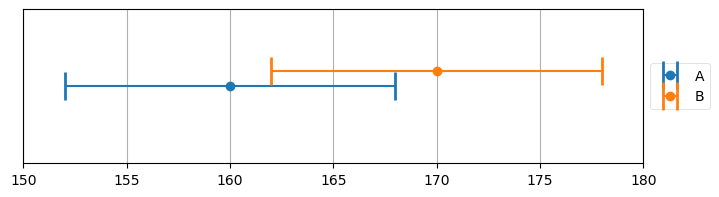

In [3]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(160, 8, 'A'), (170, 8, 'B')], xlims=(150, 180))

Несколько слов о том, как я создал этот сюжет. Я импортирую код из модуля book_plots в подкаталоге `kf_book`. Для создания этого графика требуется много Python кода, который неинтересен для чтения. Я часто использую эту тактику в книге. При запуске ячейки вызывается функция `plot_errorbars()` и график вставляется в книгу.

Если вы впервые используете [Jupyter Notebook](http://jupyter.org/), приведенный выше код находится в *ячейке*. Текст "В [2]:" помечает это как ячейку, в которую вы можете вводить входные данные, а число в скобках означает, что эта ячейка была запущена второй. Чтобы запустить ячейку, щелкните по ней мышью, чтобы она была в фокусе, затем нажмите CTRL+ENTER на клавиатуре. По мере того, как мы продолжим, вы сможете изменять код внутри ячеек и запускать их повторно. Попробуйте изменить значения "160", "170" и "8" на какое-либо другое значение и запустите ячейку. Вывод на печать должен изменяться в зависимости от того, что вы ввели.

Если вы хотите просмотреть код для plot_errorbars, либо откройте его в редакторе, либо создайте новую ячейку и введите имя функции, за которым следуют два вопросительных знака. Нажмите Ctrl+Enter, и ваш браузер откроет окно с исходным кодом. Это особенность тетрадок Jupyter. Если вы хотите просто просмотреть документацию по функции, сделайте то же самое, но с одним вопросительным знаком.

```Python

    plot_errorbars??
```
или
```Python
    plot_errorbars?
```

Таким образом, 165 фунтов выглядят разумной оценкой, но здесь есть больше информации, которой мы могли бы воспользоваться. Единственные возможные веса находятся на пересечении между столбцами ошибок A и B. Например, вес в 161 фунт невозможен, потому что шкала B не может дать показания в 170 фунтов с максимальной ошибкой в 8 фунтов. Точно так же вес в 169 фунтов невозможен, потому что шкала А не может дать показания в 160 фунтов с максимальной погрешностью в 8 фунтов. В этом примере единственно возможные веса находятся в диапазоне от 162 до 168 фунтов.

Это пока не позволяет нам найти лучшую оценку веса, но давайте еще немного поиграем в "что, если". Что, если нам сейчас скажут, что A в три раза точнее, чем B? Рассмотрим 5 вариантов, которые мы перечислили выше. По-прежнему нет смысла выбирать число за пределами диапазона A и B, поэтому мы не будем их рассматривать. Возможно, кажется более убедительным выбрать A в качестве нашей оценки - в конце концов, мы знаем, что это более точно, почему бы не использовать его вместо B? Может ли B улучшить наши знания по сравнению с A в одиночку?

Ответ, возможно, противоречащий интуиции, таков: да, это возможно. Во-первых, давайте посмотрим на те же измерения A = 160 и B = 170, но с погрешностью A $\pm$ 3 фунтов а погрешность B в 3 раза больше, $\pm$ 9 фунтов.

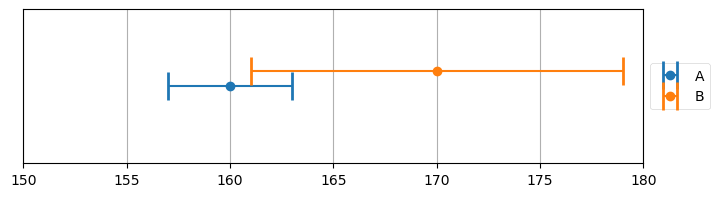

In [4]:
plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

Перекрытие полос ошибок A и B является единственно возможным истинным весом. Это перекрытие меньше, чем ошибка в A в одиночку. Что еще более важно, в этом случае мы видим, что перекрытие не включает 160 фунтов или 165 фунтов. Если бы мы использовали измерение только из A, потому что оно более точное, чем B, мы бы дали оценку в 160 фунтов. Если мы усредним A и B, то получим 165 фунтов. Ни один из этих весов невозможен, учитывая наши знания о точности весов. Включив измерение B, мы дали бы оценку где-то между 161 фунтом и 163 фунтами, пределы пересечений двух полос ошибок.

Давайте доведем это до крайних пределов. Предположим, мы знаем, что шкала А имеет точность до 1 фунта. Другими словами, если мы действительно весим 170 фунтов, это может означать 169, 170 или 171 фунт. Мы также знаем, что весы имеют точность до 9 фунтов. Мы проводим взвешивание на каждой шкале и получаем A=160, а B=170. Каким мы должны оценить наш вес? Давайте посмотрим на это графически.

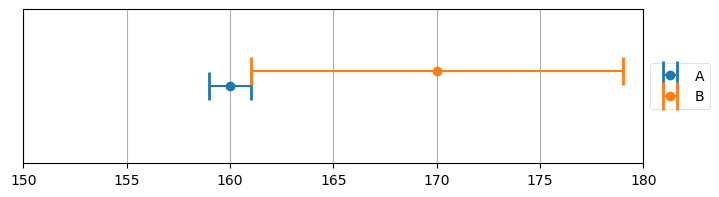

In [5]:
plot_errorbars([(160, 1, 'A'), (170, 9, 'B')], xlims=(150, 180))

Здесь мы видим, что единственно возможный вес составляет 161 фунт. Это важный результат. С помощью двух относительно неточных датчиков мы можем получить чрезвычайно точный результат.

**Таким образом, два датчика, даже если один менее точен, чем другой, лучше, чем один.** Я буду твердить об этом до конца книги. Мы никогда не бросаем слов на ветер, какими бы плохими они не были. Мы будем разрабатывать математику и алгоритмы, которые позволят нам включить все возможные источники информации для формирования наилучшей возможной оценки.

Однако мы отклонились от нашей проблемы. Ни один клиент не захочет покупать несколько весов, и, кроме того, мы изначально исходили из предположения, что все весы были одинаково точными. Это понимание использования всех измерений независимо от точности сыграет большую роль позже, так что не забывайте об этом.

Что, если у меня есть одни весы, но я взвешиваюсь много раз? Мы пришли к выводу, что если бы у нас были две шкалы одинаковой точности, мы должны были бы усреднить результаты их измерений. Что, если я взвесюсь 10 000 раз на одних весах? Мы уже говорили, что шкала с равной вероятностью вернет слишком большое число, как и слишком маленькое. Не так уж сложно доказать, что среднее значение большого количества весов будет очень близко к фактическому весу, но давайте пока напишем симуляцию. Я буду использовать NumPy, часть [SciPy](https://scipy.org/) экосистему для вычислений.

In [13]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print(f'Average of measurements is {mean:.4f}')

Average of measurements is 164.9610


Точное напечатанное число зависит от вашего генератора случайных чисел, но оно должно быть очень близко к 165.

Этот код делает одно предположение, которое, вероятно, неверно, - что шкала с такой же вероятностью покажет 160, как и 165 при истинном весе 165 фунтов. Это почти никогда не бывает правдой. Реальные датчики с большей вероятностью получат показания, близкие к истинному значению, и с меньшей вероятностью получат показания, чем дальше они удаляются от истинного значения. Мы подробно рассмотрим это в главе о Гауссе. На данный момент я буду использовать без дальнейших объяснений функцию `numpy.random.normal()`, которая будет выдавать больше значений ближе к 165 фунтам и меньше дальше. Пока примите на веру, что это приведет к шумным измерениям, подобным тому, как работает реальная шкала.

In [11]:
mean = np.random.normal(165, 5, size=10000).mean()
print(f'Average of measurements is {mean:.4f}')

Average of measurements is 164.9785


Опять же, ответ очень близок к 165.

Хорошо, отлично, у нас есть ответ на нашу проблему с датчиками! Но это не очень практичный ответ. Ни у кого не хватает терпения взвеситься десять тысяч или даже дюжину раз.

Итак, давайте поиграем в "что, если". Что, если бы вы измеряли свой вес один раз в день и получили показания 170, 161, а затем 169? Вы набрали вес, похудели или все это просто шумные измерения? 

Мы действительно не можем сказать. Первое измерение составило 170, а последнее - 169, что означает потерю 1 фунта. Но если шкала имеет точность только до 10 фунтов, это объясняется шумом. Я действительно мог бы набрать вес; возможно, мой вес в первый день составлял 165 фунтов, а на третий - 172. Можно получить эти показания с таким увеличением веса. Мои весы говорят мне, что я теряю вес, и я на самом деле набираю вес! Давайте посмотрим на это в таблице. Я нанес измерения вместе с полосами ошибок, а затем некоторые возможные увеличения / потери веса, которые могут быть объяснены этими измерениями пунктирными зелеными линиями.

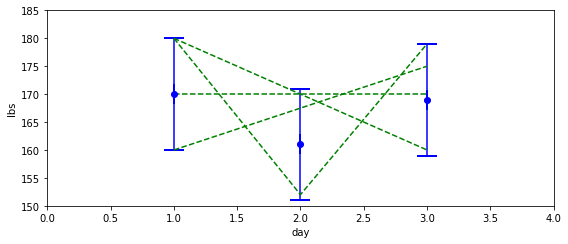

In [14]:
import kf_book.gh_internal as gh
gh.plot_hypothesis1()

Как мы можем видеть, существует экстремальный диапазон изменений веса, который можно было бы объяснить этими тремя измерениями. На самом деле, существует бесконечное количество вариантов. Должны ли мы сдаться? Только не я! Напомним, что речь идет об измерении веса человека. Нет разумного способа для человека весить 180 фунтов на 1-й день и 160 фунтов на 3-й день. или потерять 30 фунтов за один день только для того, чтобы набрать их обратно на следующий (мы будем считать, что с человеком не произошло ампутаций или других травм). 

Поведение физической системы, которую мы измеряем, должно влиять на то, как мы интерпретируем измерения. Если бы мы взвешивали камень каждый день, мы бы приписали все отклонения шуму. Если бы мы взвешивали цистерну, питаемую дождем и используемую для домашних дел, мы могли бы поверить, что такие изменения веса реальны.
 
Предположим, я беру другой масштаб и получаю следующие измерения: 169, 170, 169, 171, 170, 171, 169, 170, 169, 170. Что говорит вам ваша интуиция? Возможно, например, что вы набирали 1 фунт каждый день, а шумные измерения просто выглядят так, как будто вы остались в том же весе. Точно так же вы могли бы терять 1 фунт в день и получать те же показания. Но возможно ли это? Какова вероятность того, что вы подбросите монетку и получите 10 орлов подряд? Не очень вероятно. Мы не можем доказать это, основываясь исключительно на этих показаниях, но вполне вероятно, что мой вес оставался стабильным. На приведенной ниже диаграмме я изобразил измерения со столбцами ошибок и вероятным истинным весом, выделенным зеленым пунктиром. Эта пунктирная линия не предназначена для того, чтобы быть "правильным" ответом на эту проблему, просто тот, который является разумным и может быть объяснен измерением.

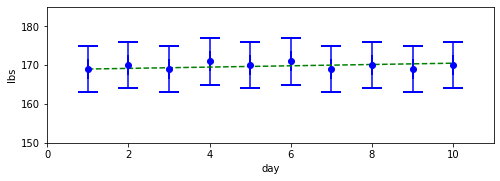

In [15]:
gh.plot_hypothesis2()

Еще одно "что, если": что, если показания были 158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0? Давайте посмотрим на диаграмму этого, а затем ответим на несколько вопросов.

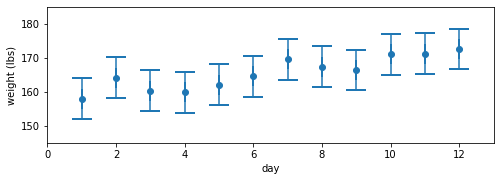

In [16]:
gh.plot_hypothesis3()

Кажется ли "вероятным", что я похудел, и это просто действительно шумные данные? Не совсем. Кажется ли вероятным, что я держал тот же вес? Опять же, нет. Эти данные имеют тенденцию к росту с течением времени; не равномерно, но определенно вверх. Мы не можем быть уверены, но это выглядит как увеличение веса, и при этом значительное увеличение веса. Давайте проверим это предположение еще на нескольких графиках. Часто бывает проще "просмотреть" данные в диаграмме, чем в таблице.

Итак, давайте рассмотрим две гипотезы. Во-первых, давайте предположим, что наш вес не изменился. Чтобы получить это число, мы договорились, что должны усреднить измерения. Давайте посмотрим на это.


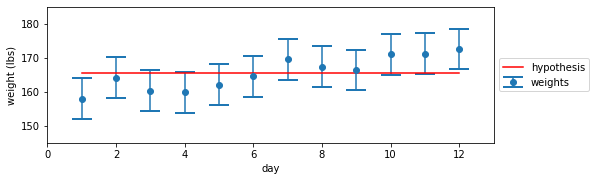

In [17]:
gh.plot_hypothesis4()

Это выглядит не очень убедительно. На самом деле, мы видим, что нет горизонтальной линии, которую мы могли бы нарисовать внутри всех полос ошибок.

Теперь давайте предположим, что мы набрали вес. Сколько? Я не знаю, но NumPy знает! Мы хотим провести линию через измерения, которая выглядит "примерно" правильно. У NumPy есть функции, которые будут делать это в соответствии с правилом, называемым "подгонка по наименьшим квадратам". Давайте не будем беспокоиться о деталях этого вычисления (я использую [polyfit()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html), если вам интересно), и просто постройте график результатов.

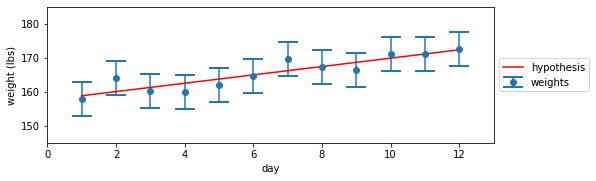

In [18]:
gh.plot_hypothesis5()

Это выглядит намного лучше, на мой взгляд. Обратите внимание, что теперь линия лежит очень близко к каждому измерению, тогда как на предыдущем графике прямая часто была довольно далека от измерения. Кажется гораздо более вероятным, что я набрал вес, чем то, что я не набрал никакого веса. Действительно ли я набрал 13 фунтов? Кто может сказать? На это, кажется, невозможно ответить.

"Но разве это невозможно?" - восклицает коллега.

Давай попробуем что-нибудь сумасшедшее. Давайте предположим, что я знаю, что набираю около одного фунта в день. Не имеет значения, откуда я знаю это прямо сейчас, предположим, я знаю, что это приблизительно правильно. Возможно, я нахожусь на диете в 6000 калорий в день, что привело бы к такому увеличению веса. Или, может быть, есть другой способ оценить прибавку в весе. Это мысленный эксперимент, детали не важны. Давайте посмотрим, сможем ли мы использовать такую информацию, если бы она была доступна.

Первое измерение составило 158. У нас нет возможности узнать что-то другое, так что давайте примем это как нашу оценку. Если наш вес сегодня 158, каким он будет завтра? Ну, мы думаем, что набираем вес на 1 фунт в день, так что наш прогноз - 159, примерно так:

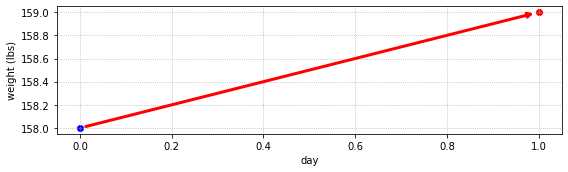

In [19]:
gh.plot_estimate_chart_1()

Окей, но что в этом хорошего? Конечно, мы могли бы предположить, что 1 фунт в день является точным, и спрогнозировать наш вес на следующие 10 дней, но тогда зачем вообще использовать весы, если мы не учитываем их показания? Итак, давайте посмотрим на следующее измерение. Мы снова встаем на весы, и они показывают 164,2 фунта.

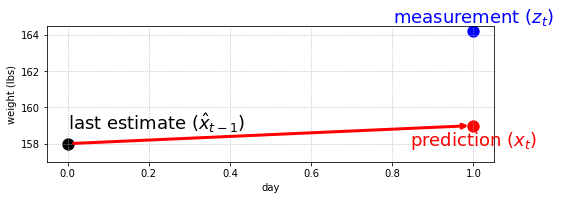

In [20]:
gh.plot_estimate_chart_2()

У нас есть проблема. Наш прогноз не соответствует нашим измерениям. Но это то, чего мы ожидали, верно? Если бы прогноз всегда точно совпадал с измерением, он не смог бы добавить какую-либо информацию в фильтр. И, конечно же, не было бы никаких причин когда-либо измерять, поскольку наши прогнозы идеальны.

> **Ключевое понимание всей этой книги содержится в следующем абзаце. Прочтите его внимательно!**

Так что же нам делать? Если мы формируем оценки только на основе измерения, то прогноз не повлияет на результат. Если мы формируем оценки только на основе прогноза, то измерение будет проигнорировано. Если это должно сработать, нам нужно использовать какое-то **сочетание прогнозирования и измерения** (я выделил ключевой момент жирным шрифтом).

Смешивание двух значений - это очень похоже на проблему с двумя масштабами ранее. Используя те же рассуждения, что и раньше, мы можем видеть, что единственное, что имеет смысл, - это выбрать число между предсказанием и измерением. Например, оценка в 165 не имеет смысла, как и 157. Наши оценки должны находиться в диапазоне от 159 (прогноз) до 164,2 (измерение).

Еще раз повторяю, это важно. Мы договорились, что при представлении двух значений с ошибками мы должны сформировать оценку на полпути между этими двумя значениями. Не имеет значения, как были сгенерированы эти значения. В начале главы у нас было два измерения, но теперь у нас есть одно измерение и одно предсказание. Рассуждения и, следовательно, математика одинаковы в обоих случаях. Мы *никогда* не выбрасываем информацию на ветер. Я серьезно. Я вижу так много коммерческого программного обеспечения, которое выбрасывает зашумленные данные. Не делай этого! Наш прогноз увеличения веса может быть не очень точным, но пока есть какая-то информация, мы должны ее использовать.

Я должен настаивать, чтобы ты остановился и действительно подумал об этом. Все, что я сделал, - это заменил неточную шкалу неточным прогнозом веса, основанным на физиологии человека. Это все еще данные. Математика не знает, были ли данные получены из шкалы или из прогноза. У нас есть два фрагмента данных с определенным количеством шума, и мы хотим их объединить. В оставшейся части этой книги мы собираемся разработать некоторые довольно сложные математические вычисления для выполнения этих вычислений, но математику никогда не волнует, откуда берутся данные, она производит вычисления только на основе значения и точности этих значений.

Должна ли оценка находиться на полпути между измерением и прогнозом? Возможно, но в целом кажется, что мы могли бы знать, что наш прогноз более или менее точен по сравнению с измерениями. Вероятно, точность нашего прогноза отличается от точности шкалы. Вспомните, что мы делали, когда шкала A была намного точнее шкалы B - мы масштабировали ответ так, чтобы он был ближе к A, чем B. Давайте посмотрим на это на диаграмме.

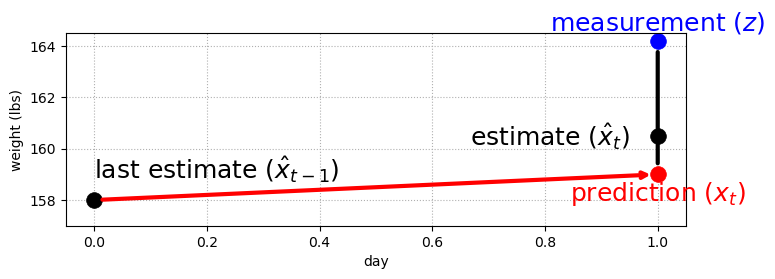

In [44]:
gh.plot_estimate_chart_3()

Теперь давайте попробуем использовать случайно выбранное число для масштабирования нашей оценки: $\frac{4}{10}$. Наша оценка будет составлять четыре десятых измерения, а остальное будет зависеть от прогноза. Другими словами, мы выражаем здесь убеждение, убеждение в том, что прогноз несколько более вероятен, чем измерение. Мы вычисляем это как

$$\mathtt{оценка} = \mathtt{прогноз} + \frac{4}{10}(\mathtt{измерение} - \mathtt{прогноз})$$

Разница между измерением и прогнозом называется *остаточной*, которая изображена черной вертикальной линией на графике выше. Это станет важным значением для последующего использования, поскольку оно представляет собой точное вычисление разницы между измерениями и выходными данными фильтра. Меньшие остатки означают более высокую производительность.

Давайте запрогаем это и посмотрим результаты, когда мы протестируем его с рядом весов сверху. Мы должны принять во внимание еще один фактор. Увеличение веса измеряется в единицах $\frac{фунты}{время}$, поэтому в общих чертах нам нужно будет добавить временной шаг $t$, который мы установим равным 1 (день).

Я вручную сгенерировал данные о весе, чтобы они соответствовали истинному стартовому весу в 160 фунтов и прибавке в весе на 1 фунт в день. Другими словами, в первый день (нулевой день) истинный вес составляет 160 фунтов, на второй день (первый день, первый день взвешивания) истинный вес составляет 161 фунт и так далее.

Нам нужно сделать предположение относительно начального веса. Еще слишком рано говорить о стратегиях инициализации, поэтому пока я буду считать, что 160 фунтов.

In [52]:
from kf_book.book_plots import figsize
import matplotlib.pyplot as plt

weights = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 
           169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

time_step = 1.0  # 1 день
scale_factor = 4.0/10

def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # хранилище для отфильтрованных результатов
    estimates, predictions = [estimated_weight], []

    # в большинстве литературы по фильтрам для измерений используется "z"
    for z in weights: 
        # предсказать новую позицию
        predicted_weight = estimated_weight + gain_rate * time_step

        # обновление фильтра 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # сохранение и вывод в лог
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

initial_estimate = 160.
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)     

previous estimate: 160.00, prediction: 161.00, estimate 159.80
previous estimate: 159.80, prediction: 160.80, estimate 162.16
previous estimate: 162.16, prediction: 163.16, estimate 162.02
previous estimate: 162.02, prediction: 163.02, estimate 161.77
previous estimate: 161.77, prediction: 162.77, estimate 162.50
previous estimate: 162.50, prediction: 163.50, estimate 163.94
previous estimate: 163.94, prediction: 164.94, estimate 166.80
previous estimate: 166.80, prediction: 167.80, estimate 167.64
previous estimate: 167.64, prediction: 168.64, estimate 167.75
previous estimate: 167.75, prediction: 168.75, estimate 169.65
previous estimate: 169.65, prediction: 170.65, estimate 170.87
previous estimate: 170.87, prediction: 171.87, estimate 172.16


[158.0,
 164.2,
 160.3,
 159.9,
 162.1,
 164.6,
 169.6,
 167.4,
 166.4,
 171.0,
 171.2,
 172.6]

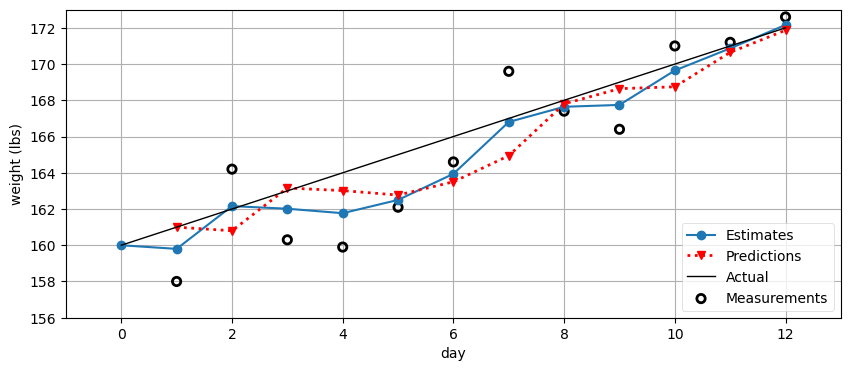

In [53]:
# отрисовка результатов
from kf_book import book_plots
book_plots.set_figsize(10)
gh.plot_gh_results(weights, estimates, predictions, [160, 172])
weights

Это очень хорошо! Здесь много данных, так что давайте поговорим о том, как их интерпретировать. Толстая синяя линия показывает оценку, полученную из фильтра. Он начинается на 0-й день с начальной оценкой в 160 фунтов. Красная линия показывает прогноз, сделанный на основе веса предыдущего дня. Итак, в первый день предыдущий вес составлял 160 фунтов, прибавка в весе составляет 1 фунт, и, таким образом, первый прогноз составляет 161 фунт. Таким образом, оценка в первый день находится на полпути между прогнозом и измерением в 159,8 фунтов. Под диаграммой находится распечатка предыдущего веса, прогнозируемого веса и новой оценки на каждый день. Наконец, тонкая черная линия показывает фактическую прибавку в весе взвешиваемого человека.

Пройдите через это для каждого дня, убедившись, что вы понимаете, как были сформированы прогнозы и оценки на каждом этапе. Обратите внимание, что оценка всегда находится между измерением и прогнозом.

Оценки не являются прямой линией, но они более прямые, чем измерения, и несколько близки к созданной нами линии тренда. Кроме того, кажется, что со временем все становится лучше.

Результаты фильтра могут показаться вам довольно глупыми; конечно, данные будут выглядеть хорошо, если мы примем вывод, что наша прибавка в весе составляет около 1 фунта в день! Давайте посмотрим, что делает фильтр, если наше первоначальное предположение неверно. Давайте спрогнозируем, что потеря веса составляет 1 фунт в день:

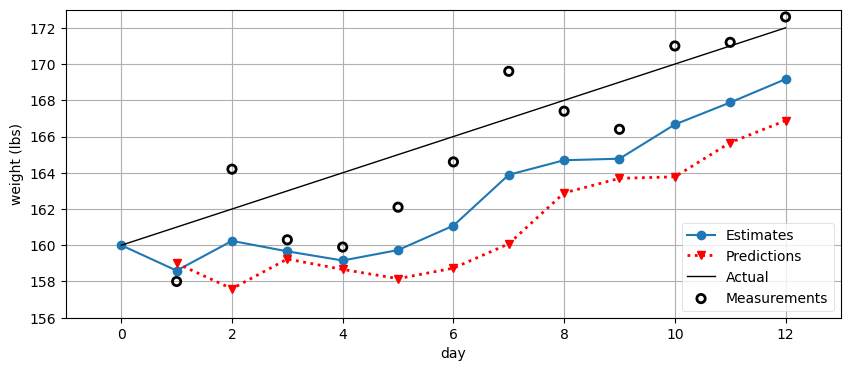

In [55]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [160, 172])

Это не так уж впечатляет. Оценки быстро расходятся с измерениями. Очевидно, что фильтр, который требует от нас правильного определения скорости изменения, не очень полезен. Даже если наше первоначальное предположение было правильным, фильтр выйдет из строя, как только эта скорость изменения изменится. Если я перестану переедать, фильтру будет крайне трудно приспособиться к этому изменению. Обратите внимание, что он настраивается! Оценки растут, даже несмотря на то, что мы говорим, что теряем 1 фунт в день. Он просто не может приспособиться достаточно быстро.

Но "что, если"? Что, если вместо того, чтобы оставить прибавку в весе при первоначальном предположении в 1 фунт (или что-то еще), мы вычислим ее на основе существующих измерений и оценок. В первый день наша оценка веса составляет:

$$
(160 + 1) + \frac{4}{10}(158-161) = 159.8
$$

На следующий день мы измеряем 164,2, что подразумевает прибавку в весе на 4,4 фунта (поскольку 164,2 - 159,8 = 4,4), а не на 1. Можем ли мы как-то использовать эту информацию? Это кажется правдоподобным. В конце концов, само измерение веса основано на реальном измерении нашего веса, поэтому в нем содержится полезная информация. Наша оценка нашего увеличения веса, возможно, не идеальна, но это, безусловно, лучше, чем просто предполагать, что ваш прирост составляет 1 фунт. Данные лучше, чем предположения, даже если они зашумлены.

Люди действительно возражают на этом этапе, поэтому убедитесь, что вы согласны. Два зашумленных измерения веса дают нам подразумеваемую прибавку / потерю веса. Эта оценка будет очень неточной, если измерения будут неточными, но в этом вычислении все еще есть информация. Представьте, что вы взвешиваете корову на весах с точностью до 1 фунта, и это показывает, что корова набрала 10 фунтов. Корова могла набрать от 8 до 12 фунтов, в зависимости от ошибок, но мы знаем, что она набрала вес и примерно на сколько. Это информация. Что мы делаем с информацией? Никогда не выбрасывай его!

Возвращаюсь к своей диете. Должны ли мы установить новую прибавку в день на 4,4 фунта? Вчера мы думали, что прибавка в весе составила 1 фунт, сегодня мы думаем, что это 4,4 фунта. У нас есть два числа, и мы хотим как-то их объединить. Хм, похоже, у нас снова та же проблема. Давайте воспользуемся нашим же инструментом и единственным инструментом, который у нас пока есть, - выберем значение на полпути между ними. На этот раз я буду использовать другой произвольно выбранный номер, $\frac{1}{3}$. Уравнение идентично тому, что и для оценки веса, за исключением того, что мы должны учитывать время, потому что это скорость (прирост/день):

$$\text{новый прирост} = \text{старый прирост} + \frac{1}{3}\frac{\text{измерение - прогноз веса}}{1 \text{ день}}
$$

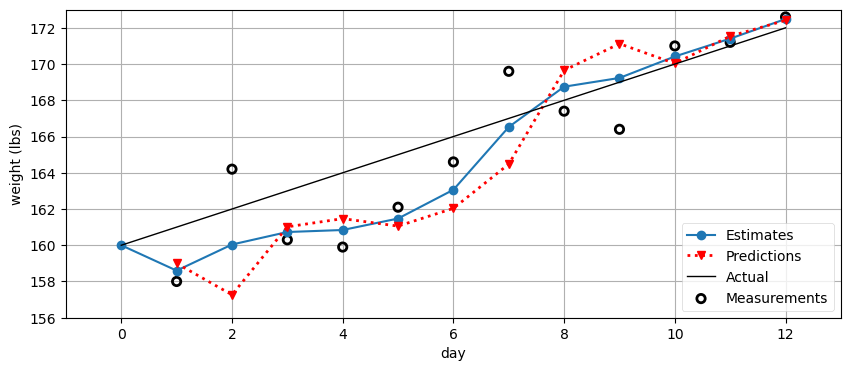

In [57]:
weight = 160.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
weight_scale = 4./10
gain_scale = 1./3
estimates = [weight]
predictions = []

for z in weights:
    # прогноз
    weight = weight + gain_rate*time_step
    gain_rate = gain_rate
    predictions.append(weight)
    
    # обновление    
    residual = z - weight
    
    gain_rate = gain_rate + gain_scale   * (residual/time_step)
    weight    = weight    + weight_scale * residual
  
    estimates.append(weight)

gh.plot_gh_results(weights, estimates, predictions, [160, 172])

Я думаю, что это начинает выглядеть действительно хорошо. Из-за плохого первоначального предположения о том, что прибавка в весе равна -1, фильтру требуется несколько дней, чтобы точно предсказать вес, но как только он это делает, он начинает точно отслеживать вес. Мы не использовали никакой методологии для выбора наших коэффициентов масштабирования $\frac{4}{10}$ и $\frac{1}{3}$ (на самом деле, они являются плохим выбором для этой задачи), но в остальном вся математика вытекала из очень разумных предположений. Напомним, что вы можете изменить значение параметра `time_step` на большее значение и повторно запустить ячейку, если хотите увидеть пошаговое построение графика.
Один последний момент, прежде чем мы продолжим. На этапе прогнозирования я написал строку
```python
gain_rate = gain_rate
``` 
Очевидно, что это не имеет никакого эффекта и может быть удалено. Я написал это, чтобы подчеркнуть, что на этапе прогнозирования вам нужно предсказать следующее значение для всех переменных, как `weight`, так и `gain_rate`. Это станет актуальным в ближайшее время. В этом случае мы предполагаем, что коэффициент усиления не меняется, но когда мы обобщим этот алгоритм, мы уберем это предположение. 

## Фильтр g-h

Этот алгоритм известен как [g-h фильтр](https://en.wikipedia.org/wiki/Alpha_beta_filter) или фильтр $\alpha$-$\beta$. $g$ и $h$ относятся к двум коэффициентам масштабирования, которые мы использовали в нашем примере. $g$ - это масштабирование, которое мы использовали для измерения (вес в нашем примере), а $h$ - масштабирование для изменения измерения с течением времени (фунты/ день в нашем примере). $\alpha$ и $\beta$ - это просто разные имена, используемые для этих факторов.

Этот фильтр является основой для огромного количества фильтров, в том числе фильтра Калмана. Другими словами, фильтр Калмана - это форма фильтра g-h, который я докажу позже в книге. Как и фильтр наименьших квадратов, о котором вы, возможно, слышали, и фильтр Бенедикта-Борднера, которого у вас, вероятно, нет. Каждый фильтр имеет свой способ присвоения значений $g$ и $h$, но в остальном алгоритмы идентичны. Например, фильтр Бенедикта-Борднера присваивает константу $g$ и $h$, ограниченную определенным диапазоном значений. Другие фильтры, такие как фильтры Калмана, будут динамически изменять $g$ и $h$ на каждом временном шаге.

**Позвольте мне повторить ключевые моменты, поскольку они так важны**. Если вы не поймете этого, вы не поймете остальную часть книги. Если вы их понимаете, то остальная часть книги будет разворачиваться для вас естественным образом как математические разработки различных вопросов "что, если", которые мы зададим о $g$ и $h$. Математика может выглядеть совершенно по-другому, но алгоритм будет точно таким же.

* Несколько точек данных более точны, чем одна точка данных, поэтому ничего не выбрасывайте, независимо от того, насколько это неточно.
* Всегда выбирайте число на полпути между двумя точками данных, чтобы получить более точную оценку.
* Прогнозируйте следующее измерение и скорость изменения на основе текущей оценки и того, насколько, по нашему мнению, оно изменится.
* Затем новая оценка выбирается как часть пути между прогнозом и следующим измерением, масштабируемым в зависимости от того, насколько точным является каждое из них.

Давайте посмотрим на визуальное изображение алгоритма.

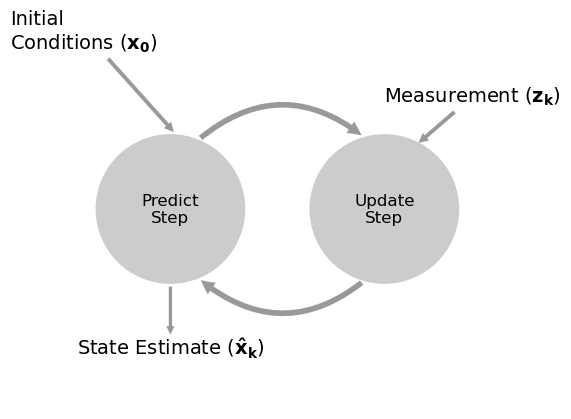

In [58]:
book_plots.predict_update_chart()

Позвольте мне ввести более формальную терминологию. *Система* - это объект, который мы хотим оценить. В этой главе система - это то, что мы пытаемся взвесить. В некоторых текстах это называется "растением". Эта терминология взята из теории систем управления. https://en.wikipedia.org/wiki/Plant_(control_theory)

*Состояние* системы - это текущая конфигурация или значения той системы, которая представляет для нас интерес. Нас интересуют только показания веса. Если я положу на весы 100 кг, то состояние будет равно 100 кг. Мы определяем состояние, основываясь на том, что имеет отношение к нам. Цвет шкалы для нас не имеет значения, поэтому мы не включаем эти значения в состояние. Инженер по контролю качества производителя может включить цвет в состояние, чтобы она могла отслеживать и контролировать производственный процесс. 

*Измерение* - это измеренное значение системы. Измерения могут быть неточными, поэтому они могут иметь не то же значение, что и состояние.

*Оценка состояния* - это оценка состояния нашего фильтра. Например, для веса 100 кг наша оценка может составлять 99,327 кг из-за ошибок датчика. Обычно это сокращается до *оценки*, и я сделал это в этой главе.

Другими словами, состояние следует понимать как фактическую ценность системы. Это значение обычно *скрыто* для нас.  Если бы я встал на весы, у вас было бы *измерение*. Мы называем это *наблюдаемым*, поскольку вы можете непосредственно наблюдать это измерение. Напротив, вы никогда не сможете непосредственно наблюдать за моим весом, вы можете только измерить его. 

Этот язык "скрытого" и "наблюдаемого" важен. Любая задача оценки состоит в формировании оценки скрытого состояния с помощью наблюдаемых измерений. Если вы читаете литературу, эти термины используются при определении проблемы, поэтому вам должно быть комфортно с ними.

Мы используем *модель процесса* для математического моделирования системы. В этой главе наша модель процесса основана на предположении, что мой сегодняшний вес равен вчерашнему весу плюс моя прибавка в весе за последний день. Модель процесса не моделирует или иным образом не учитывает датчики. Другим примером может служить модель процесса для автомобиля. Модель процесса может быть такой: "расстояние равно скорости, умноженной на время. Эта модель не идеальна, так как скорость автомобиля может изменяться в течение ненулевого промежутка времени, шины могут скользить по дороге и так далее. *Системная ошибка* или *ошибка процесса* - это ошибка в этой модели. Мы никогда не знаем это значение точно; если бы мы знали, мы могли бы усовершенствовать нашу модель, чтобы иметь нулевую ошибку. В некоторых текстах используются *модель завода* и *ошибка завода*. Вы также можете увидеть *модель системы*. Все они означают одно и то же.

Этап прогнозирования известен как *распространение системы*. Он использует *модель процесса* для формирования новой *оценки состояния*. Из-за *ошибки процесса* эта оценка является несовершенной. Предполагая, что мы отслеживаем данные с течением времени, мы говорим, что мы *распространяем* состояние в будущее. Некоторые тексты называют это "эволюцией". 

Шаг обновления известен как *обновление измерений*. Одна итерация обновления системы распространения и измерений известна как *эпоха*. 

Теперь давайте рассмотрим несколько различных проблемных областей, чтобы лучше понять этот алгоритм. Рассмотрим проблему попытки отследить поезд на рельсах. Трасса ограничивает положение поезда очень определенным регионом. Кроме того, поезда большие и медленные. Им требуется много минут, чтобы значительно замедлиться или ускориться. Итак, если я знаю, что поезд находится на отметке километра 23 км в момент времени t и движется со скоростью 18 км/ч, я могу быть чрезвычайно уверен в прогнозировании его положения в момент времени t + 1 секунда. Почему это так важно? Предположим, мы можем измерить его положение только с точностью до 250 метров. Поезд движется со скоростью 18 км/ч, что составляет 5 метров в секунду. При t + 1 секунда поезд будет находиться на расстоянии 23,005 км, но измерение может быть где угодно от 22,755 км до 23,255 км. Таким образом, если следующее измерение показывает, что позиция находится на отметке 23,4, мы знаем, что это должно быть неточно. Даже если в момент времени t машинист нажмет на тормоза, поезд все равно будет очень близок к 23,005 км, потому что поезд не может сильно замедлиться за 1 секунду. Если бы мы должны были разработать фильтр для этой проблемы (и мы сделаем это немного позже в этой главе!) мы хотели бы разработать фильтр, который придавал бы очень высокий вес прогнозу по сравнению с измерением. 

Теперь рассмотрим проблему отслеживания брошенного мяча. Мы знаем, что баллистический объект движется по параболе в вакууме, находясь в гравитационном поле. Но мяч, брошенный на Землю, находится под влиянием сопротивления воздуха, поэтому он не движется по идеальной параболе. Бейсбольные питчеры пользуются этим фактом, когда бросают кривые мячи. Допустим, мы отслеживаем мяч внутри стадиона с помощью компьютерного зрения, чем я занимаюсь на работе. Точность отслеживания компьютерным зрением может быть скромной, но предсказание будущего положения мяча, предполагая, что он движется по параболе, также не является чрезвычайно точным. В этом случае мы, вероятно, разработали бы фильтр, который придавал бы примерно равный вес измерению и прогнозированию.

Теперь подумайте о том, чтобы попытаться отследить воздушный шар для вечеринки с гелием во время урагана. У нас нет законной модели, которая позволила бы нам предсказать поведение воздушного шара, кроме как в очень коротких временных масштабах (например, мы знаем, что воздушный шар не может пролететь 10 миль за 1 секунду). В этом случае мы бы разработали фильтр, который выделял бы измерения по сравнению с прогнозами.

Большая часть этой книги посвящена выражению проблем в последних трех параграфах математически, что затем позволяет нам найти оптимальное решение (в некотором математическом смысле). В этой главе мы просто будем присваивать разные значения $g$ и $h$ более интуитивным и, следовательно, менее оптимальным способом. Но основная идея состоит в том, чтобы смешать несколько неточные измерения с несколько неточными моделями поведения систем, чтобы получить отфильтрованную оценку, которая лучше, чем любой источник информации сам по себе.

Мы можем выразить это в виде алгоритма:

**Инициализация**

    1. Инициализируйте состояние фильтра
    2. Инициализировать наше состояние

**Прогноз**

    1. Используйте поведение системы для прогнозирования состояния на следующем временном шаге
    2. Скорректируйте убеждения, чтобы учесть неопределенность в прогнозировании
    
**Обновление**

    1. Получите измерение и связанное с ним убеждение в его точности
    2. Вычисление остатка между оцененным состоянием и измерением
    3. Новая оценка находится где-то на остаточной линии
    
Мы будем использовать этот же алгоритм на протяжении всей книги, хотя и с некоторыми изменениями.

## Обозначение

Я начну знакомить с обозначениями и именами переменных, используемыми в литературе. Кое-что из этого уже использовалось в приведенных выше диаграммах. Измерение обычно обозначается как $z$, и это то, что мы будем использовать в этой книге (в некоторой литературе используется $y$). Индекс $k$ указывает временной шаг, поэтому $z_k$ - это данные для этого временного шага. Жирный шрифт обозначает вектор или матрицу. До сих пор мы рассматривали только один датчик и, следовательно, одно измерение датчика, но в целом у нас может быть *n* датчиков и *n* измерений. $\mathbf{x}$ обозначает наше состояние и выделено жирным шрифтом, чтобы обозначить, что это вектор. Для нашего примера шкалы он представляет как начальный вес, так и начальную скорость набора веса, например:

$$\mathbf{x} = \begin{bmatrix}x \\ \dot{x}\end{bmatrix}$$

Здесь я использую ньютоновское обозначение точки над x для обозначения скорости. Точнее, точка подразумевает производную от x по времени, которая, конечно же, является скоростью. Для веса 62 кг с приростом 0,3 кг/день мы имеем

$$\mathbf{x} = \begin{bmatrix}62 \\ 0.3\end{bmatrix}$$

Итак, алгоритм прост. Состояние инициализируется с помощью $\mathbf{x_0}$, начальной оценки. Затем мы вводим цикл, предсказывая состояние для времени или шага $k$ по значениям времени (или шага) $k-1$. Затем мы получаем измерение $z_k$ и выбираем некоторую промежуточную точку между измерениями и прогнозом, создавая оценку $\mathbf{x}_k$.

## Упражнение: Напишите генетический алгоритм

В приведенном выше примере я явно запрогал это, чтобы решить проблему взвешивания, которую мы обсуждали на протяжении всей главы. Например, переменные называются "weight_scale", "gain" и так далее. Я сделал это, чтобы упростить выполнение алгоритма - вы можете легко увидеть, что мы правильно выполнили каждый шаг. Но это код, написанный ровно для одной задачи, и алгоритм одинаков для любой задачи. Итак, давайте перепишем код, чтобы он был универсальным - для работы с любой проблемой. Используйте эту сигнатуру функции:

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Выполняет фильтр g-h для 1 переменной состояния с фиксированными g и h.

    'data' содержит данные, подлежащие фильтрации.
    'x0' является начальным значением для нашей переменной состояния
    'dx' является начальной скоростью изменения для нашей переменной состояния
    'g' является масштабным коэффициентом g-h для g-h
    'h' является масштабным коэффициентом h g-h
    'dt' это длина временного шага
    """
```

Возвращает данные в виде массива NumPy, а не списка. Протестируйте его, передав те же данные о весе, что и раньше, отобразите результаты и визуально определите, работает ли он.

In [70]:
from kf_book.gh_internal import plot_g_h_results
def g_h_filter(data, x0, dx, g, h, dt):
    pass #  ваш код

# раскомментируйте, чтобы запустить фильтр и отобразить результаты
# book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
# data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
# plot_g_h_results(weights, data)

### Решение и обсуждение

[158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
[159.2   161.8   162.1   160.78  160.985 163.311 168.1   169.696
 168.204 169.164 170.892 172.629]


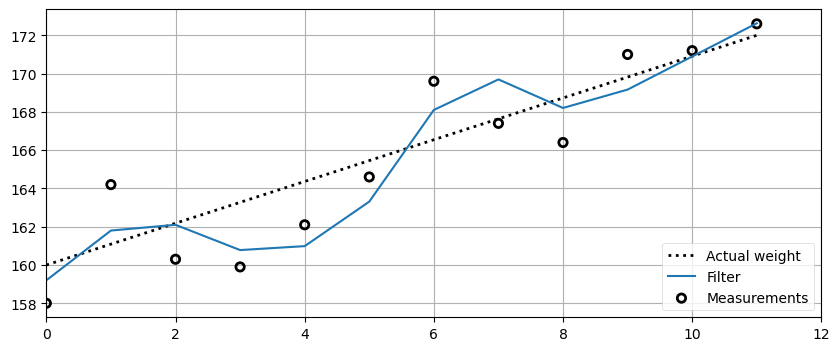

In [77]:
import matplotlib.pylab as pylab

def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # прогноз
        x_pred = x_est + (dx*dt)
        dx = dx

        # обновление
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)

book_plots.plot_track([0, 11], [160, 172], label='Actual weight')
data = g_h_filter(data=weights, x0=160., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)
print(weights)
print(data)

Это должно было быть просто. Я просто заменил имена переменных `x0`, `dx` и т.д. На имена переменных в коде увеличения веса. Больше ничего не нужно было менять.

## Выбор $g$ и $h$

Фильтр g-h - это не один фильтр, это классификация для семейства фильтров. Эли Брукнер в книге *Отслеживание и фильтрация по Калману упрощены* перечисляет 11, и я уверен, что их еще больше. Не только это, но и каждый тип фильтра имеет множество подтипов. Каждый фильтр отличается тем, как выбраны $g$ и $h$. Так что здесь я не могу дать никакого совета "один размер подходит всем". Некоторые фильтры устанавливают $g$ и $h$ в качестве констант, другие изменяют их динамически. Фильтр Калмана динамически изменяет их на каждом шаге. Некоторые фильтры позволяют $g$ и $h$ принимать любое значение в пределах диапазона, другие ограничивают зависимость одного от другого некоторой функцией $f(\dot{}), \mbox {где }g = f(h)$.

Темой этой книги является не все семейство фильтров g-h; что более важно, нас интересует байесовский аспект этих фильтров, который я еще не рассматривал. Поэтому я не буду подробно описывать выбор $g$ и $h$. *Упрощение отслеживания и фильтрации по Калману* - отличный ресурс по этой теме. Если это кажется вам странной позицией для меня, признайте, что типичная формулировка фильтра Калмана вообще не использует $g$ и $h$. Фильтр Калмана - это фильтр g-h, потому что он математически сводится к этому алгоритму. Когда мы разрабатываем фильтр Калмана, мы используем критерии проектирования, которые могут быть математически сведены к $g$ и $h$, но форма фильтра Калмана обычно является гораздо более мощным способом осмысления проблемы. Не волнуйтесь, если это не слишком ясно прямо сейчас, это прояснится, как только мы разработаем теорию фильтра Калмана.

Стоит посмотреть, как изменение $g$ и $h$ влияет на результаты, поэтому мы рассмотрим несколько примеров. Это даст нам четкое представление о фундаментальных преимуществах и ограничениях этого типа фильтров, а также поможет нам понять поведение довольно более сложного фильтра Калмана.

## Упражнение: создать функцию измерения

Теперь давайте напишем функцию, которая генерирует для нас зашумленные данные. В этой книге я моделирую зашумленный сигнал как [белый шум](https://en.wikipedia.org/wiki/White_noise). Мы еще не рассмотрели статистику, чтобы полностью понять определение белого шума. По сути, думайте об этом как о данных, которые случайным образом изменяются выше и ниже, чем сигнал без паттерна. Мы говорим, что это последовательно некоррелированная случайная величина с нулевым средним значением и конечной дисперсией. Если вы не последуете этому, то сделаете это к концу главы "Гауссианы". Возможно, вы не добьетесь успеха в этом упражнении, если не разбираетесь в статистике. Если это так, просто прочитайте решение и обсуждение.

Белый шум может быть сгенерирован с помощью `numpy.random.randn()`. Нам нужна функция, которую мы вызываем с начальным значением, количеством изменений за шаг, количеством шагов и количеством шума, которое мы хотим добавить. Он должен вернуть список данных. Протестируйте его, создав 30 точек, отфильтровав их с помощью `g_h_filter()` и построив результаты с помощью `plot_g_h_results()`.

In [73]:
# ваш код

### Решение

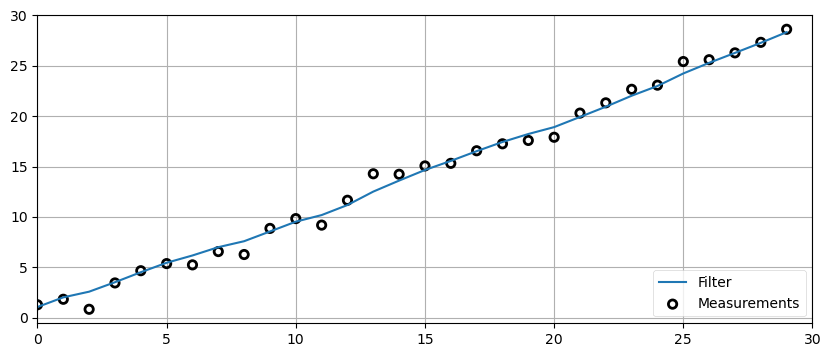

In [78]:
from numpy.random import randn
def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

### Обсуждение

`rand()` возвращает случайные числа с центром вокруг 0 - вероятность того, что они будут больше нуля, так же велика, как и меньше нуля. Оно варьируется на * одно стандартное отклонение* - не волнуйтесь, если вы не знаете, что это значит. Я построил график 3000 вызовов `randn()` - вы можете видеть, что значения сосредоточены вокруг нуля и в основном варьируются от немного меньше -1 до немного больше + 1, хотя иногда они намного больше.

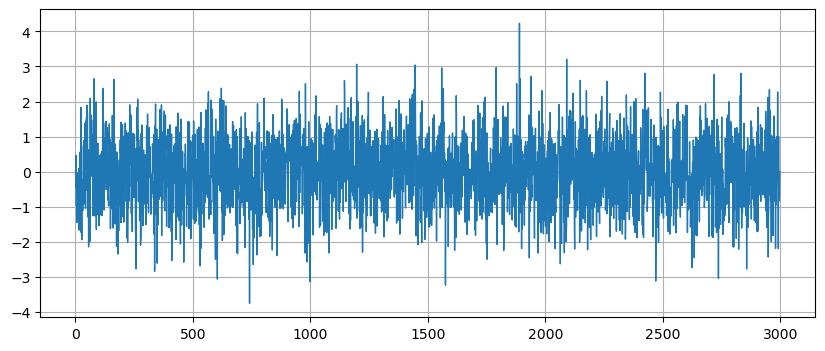

In [76]:
plt.plot([randn() for _ in range(3000)], lw=1);

## Упраженение: Плохие Начальные Условия

Теперь напишите код, который использует `gen_data` и `g_h_filter` для фильтрации 100 точек данных, которые начинаются с 5, имеют производную от 2, коэффициент масштабирования шума 10 и используют g = 0,2 и h = 0,02. Установите ваше первоначальное предположение для x равным 100.

In [79]:
# ваш код

### Решение и обсуждение

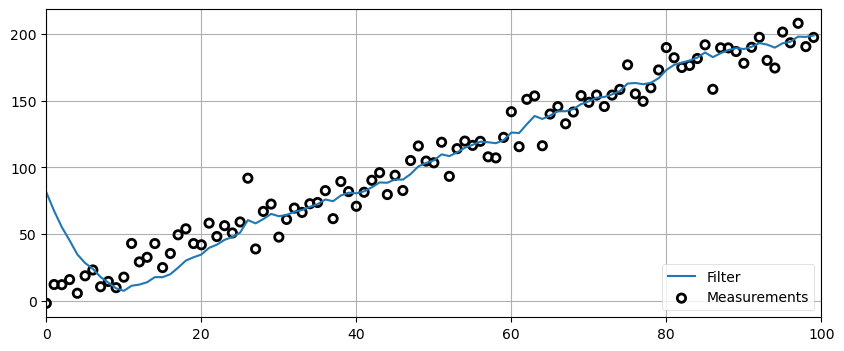

In [87]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

Фильтр начинается с оценок, которые далеки от измеренных данных из-за неправильного начального предположения, равного 100. Вы можете видеть, что он "звонит", прежде чем перейти к измеренным данным. "Звон" означает, что сигнал перекрывает и перекрывает данные по шаблону синусоидального типа. Это очень распространенное явление в фильтрах, и большая часть работы по проектированию фильтров посвящена минимизации звона. Это тема, которую мы еще не готовы затронуть, но я хотел показать вам это явление.

## Упражнение: Сильный шум

Повторите тот же тест, но на этот раз используйте коэффициент шума 100. Удалите вызов начального условия, изменив начальное условие со 100 на 5.

In [88]:
# ваш код

### Решение и обсуждение

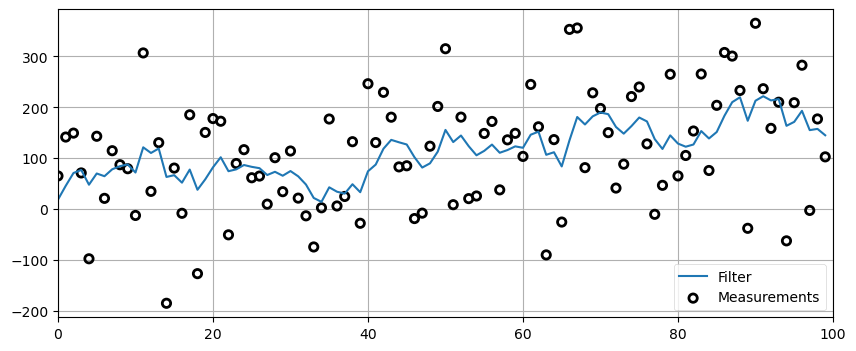

In [89]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

Мне это не кажется таким уж замечательным. Мы можем видеть, что, возможно, отфильтрованный сигнал изменяется меньше, чем зашумленный сигнал, но он далек от прямой линии. Если бы мы строили только отфильтрованный результат, никто бы не догадался, что сигнал начинается с 5 и увеличивается на 2 на каждом временном шаге. И в то время как в некоторых местах фильтр, похоже, действительно уменьшает шум, в других местах он, похоже, перекрывает и перекрывает.

На данный момент мы знаем недостаточно, чтобы действительно судить об этом. Мы добавили **много** шума; возможно, это все, что может дать фильтрация. Однако существование множества глав, помимо этой, должно наводить на мысль, что мы можем добиться гораздо большего.

## Упражнение: Эффект ускорения

Напишите новую функцию генерации данных, которая добавляет постоянный коэффициент ускорения к каждой точке данных. Другими словами, увеличивайте dx по мере вычисления каждой точки данных, чтобы скорость (dx) постоянно увеличивалась. Установите шум равным 0, $g=0,2$ и $ h = 0,02$ и постройте результаты с помощью `plot_g_h_results` или вашей собственной процедуры. Поиграйте с различными ускорениями и временными шагами. Объясни, что ты видишь.

In [90]:
# ваш код

### Решение и обсуждение

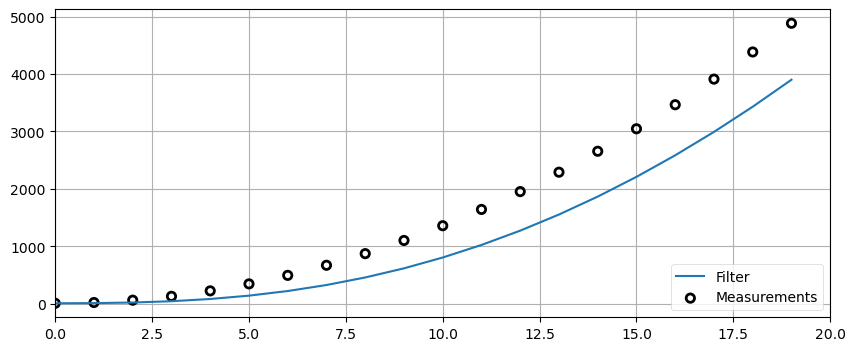

In [97]:
def gen_data(x0, dx, count, noise_factor, accel=0.):
    zs = []
    for i in range(count):
        zs.append(x0 + accel * (i**2) / 2 + dx*i + randn()*noise_factor)
        dx += accel
    return zs
   
predictions = []
zs = gen_data(x0=10., dx=0., count=20, noise_factor=0, accel=9.)
data = g_h_filter(data=zs, x0=10., dx=0., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

Каждое предсказание отстает от сигнала. Если вы подумаете о том, что происходит, это имеет смысл. Наша модель предполагает, что скорость постоянна. Фильтр g-h вычисляет первую производную от $x$ (мы используем $\dot{x}$ для обозначения производной), но не вторую производную $\ddot{x}$. Итак, мы предполагаем, что $\ddot{x}=0$. На каждом шаге прогнозирования мы прогнозируем новое значение x как $x + \dot{x}*t$. Но из-за ускорения прогноз обязательно должен отставать от фактического значения. Затем мы пытаемся вычислить новое значение для $\dot{x}$, но из-за фактора $h$ мы лишь частично адаптируем $\dot{x}$ к новой скорости. На следующей итерации мы снова потерпим неудачу.

Обратите внимание, что мы не можем внести никаких изменений в $g$ или $h$, чтобы исправить эту проблему. Это называется *ошибкой задержки* или *системной ошибкой* системы. Это фундаментальное свойство фильтров g-h. Возможно, ваш разум уже предлагает решения или обходные пути для решения этой проблемы. Как и следовало ожидать, этой проблеме было посвящено много исследований, и в этой книге мы представим различные решения этой проблемы.
> Суть "взять домой" заключается в том, что фильтр хорош только настолько, насколько хороша математическая модель, используемая для выражения системы. 

## Упражнение: Изменяющийся $g$

Теперь давайте посмотрим на эффект изменения $ g $. Прежде чем выполнить это упражнение, вспомните, что $g$ - это масштабный коэффициент для выбора между измерением и прогнозом. Как вы думаете, каким будет эффект от большого значения $ g $? Небольшая ценность?

Теперь пусть `noise_factor=50` и `dx=5`. Постройте график результатов $g = 0.1\mbox{, } 0.4,\mbox{ и } 0.8$.

In [98]:
# ваш код

### Решение и обсуждение

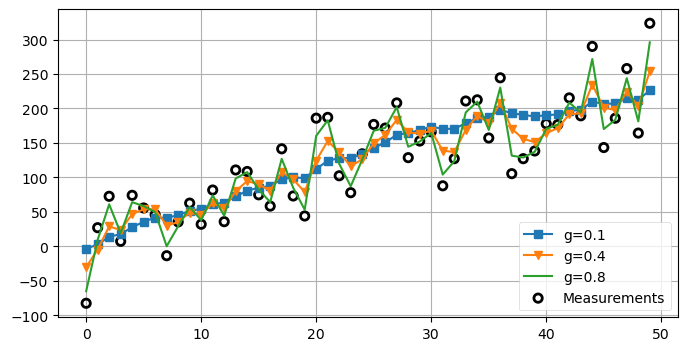

In [99]:
np.random.seed(100)
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)

Ясно, что по мере того, как $g$ становится больше, мы более внимательно следим за измерением, а не за прогнозом. Когда $g = 0.8$, мы почти точно следуем сигналу и почти не отбрасываем шум. Можно было бы наивно заключить, что $g$ всегда должно быть очень маленьким, чтобы максимизировать подавление шума. Однако это означает, что мы в основном игнорируем измерения в пользу нашего прогноза. Что происходит, когда сигнал изменяется не из-за шума, а из-за фактического изменения состояния? Давайте посмотрим. Я создам данные, которые имеют $\dot {x} = 1$ за 9 шагов, прежде чем перейти на $\dot{x} = 0$.

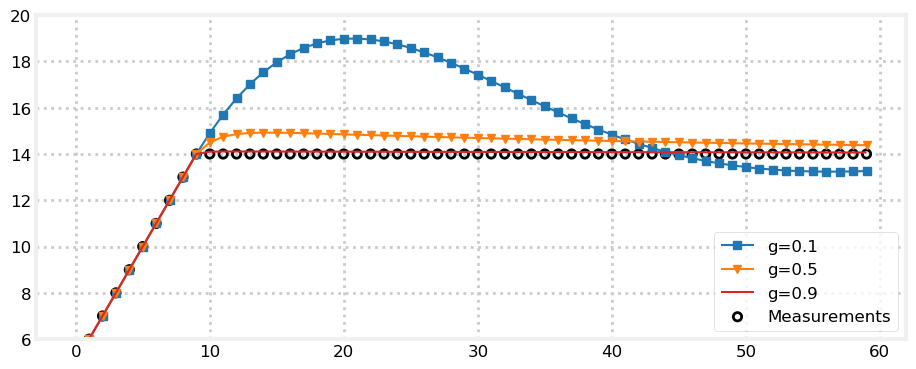

In [34]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

Здесь мы можем видеть последствия игнорирования сигнала. Мы не только отфильтровываем шум, но и законные изменения в сигнале. 

Может быть, нам нужен фильтр "Златовласка", где $g$ не слишком большой, не слишком маленький, но в самый раз? Ну, не совсем так. Как упоминалось ранее, различные фильтры выбирают $g$ и $h$ по-разному в зависимости от математических свойств задачи. Например, фильтр Бенедикта-Борднера был изобретен для минимизации временной ошибки в этом примере, где $\dot{x}$ совершает скачок шага. Мы не будем обсуждать этот фильтр в этой книге, но вот два графика, выбранных с разными допустимыми парами $g$ и $h$. Такая конструкция фильтра сводит к минимуму временные ошибки при скачках шага в $\dot {x}$ за счет того, что она не является оптимальной для других типов изменений в $\dot{x}$.

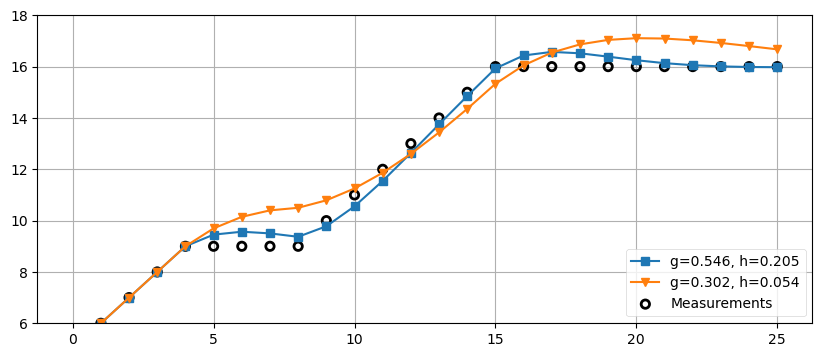

In [100]:
zs = [5,6,7,8,9,9,9,9,9,10,11,12,13,14,
      15,16,16,16,16,16,16,16,16,16,16,16]
data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.302, h=.054)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=.546, h=.205)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data2, label='g=0.546, h=0.205', marker='s', c='C0')
book_plots.plot_filter(data1, label='g=0.302, h=0.054', marker='v', c='C1')
plt.legend(loc=4)
plt.ylim([6, 18]);

## Изменяющийся $h$

Теперь давайте оставим $g$ без изменений и исследуем эффект изменения $h$. Мы знаем, что $h$ влияет на то, насколько мы предпочитаем измерение $\dot{x}$ по сравнению с нашим прогнозом. Но что это *значит*? Если наш сигнал сильно меняется (быстро относительно временного шага нашего фильтра), то большой $h$ заставит нас быстро реагировать на эти переходные изменения. Меньший $h$ заставит нас реагировать медленнее.

Мы рассмотрим три примера. У нас есть бесшумное измерение, которое медленно переходит от 0 к 1 за 50 шагов. Наш первый фильтр использует почти правильное начальное значение для $\dot{x} $ и небольшое значение $h$. Вы можете видеть на выходе, что выходной сигнал фильтра очень близок к сигналу. Второй фильтр использует очень неверное предположение о $\dot{x}=2$. Здесь мы видим, как фильтр "звонит" до тех пор, пока он не успокоится и не найдет сигнал. Третий фильтр использует те же условия, но теперь он устанавливает $h=0.5$. Если вы посмотрите на амплитуду звона, то увидите, что она намного меньше, чем на втором графике, но частота больше. Он также оседает немного быстрее, чем второй фильтр, хотя и ненамного.

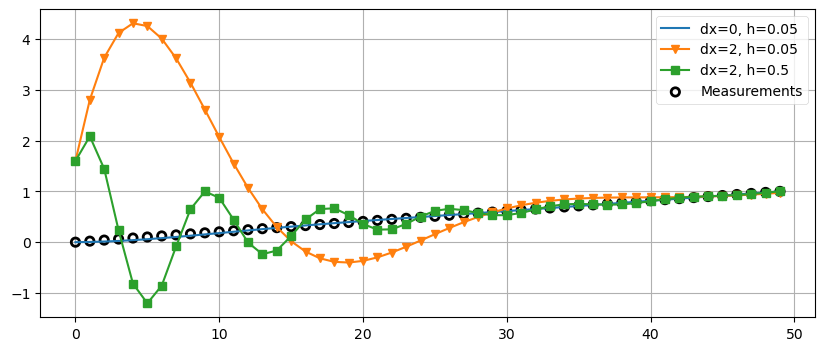

In [101]:
zs = np.linspace(0, 1, 50)

data1 = g_h_filter(data=zs, x0=0, dx=0., dt=1., g=.2, h=0.05)
data2 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.05)
data3 = g_h_filter(data=zs, x0=0, dx=2., dt=1., g=.2, h=0.5)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='dx=0, h=0.05', c='C0')
book_plots.plot_filter(data2, label='dx=2, h=0.05', marker='v', c='C1')
book_plots.plot_filter(data3, label='dx=2, h=0.5',  marker='s', c='C2')
plt.legend(loc=1);

## Интерактивный Пример

Для тех из вас, кто запускает это в Jupyter Notebook, я написал интерактивную версию фильтра, чтобы вы могли видеть эффект изменения $\dot{x}$, $g$ и $h$ в режиме реального времени. Когда вы отрегулируете ползунки для $\dot{x}$, $g$ и $h$, данные будут повторно отфильтрованы, а результаты выведены на график для вас.

Если вы действительно хотите проверить себя, прочтите следующий абзац и попробуйте предсказать результаты, прежде чем перемещать ползунки. 

Некоторые вещи, которые нужно попробовать, включают установку $g$ и $h$ на их минимальные значения. Посмотрите, как идеально фильтр отслеживает данные! Это происходит только потому, что мы точно прогнозируем увеличение веса. Измените значение $\dot{x}$ на большее или меньшее, чем 5. Фильтр должен отклоняться от данных и никогда не запрашивать их повторно. Начните добавлять обратно либо $g$, либо $h$ и посмотрите, как фильтр возвращается к данным. Посмотрите, в чем разница в строке, когда вы добавляете только $g$ против только $h$. Можете ли вы объяснить причину такой разницы? Затем попробуйте установить значение $g$ больше 1. Можете ли вы объяснить результаты? Верните $g$ к разумному значению (например, 0.1), а затем сделайте $h$ очень большим. Можете ли вы объяснить эти результаты? Наконец, установите для $g$ и $h$ их наибольшие значения. 
 
Если вы хотите изучить это подробнее, измените значение массива `zs` на значения, используемые в любой из приведенных выше диаграмм, и повторно запустите ячейку, чтобы увидеть результат.

In [103]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

## Не лги Фильтру

Вы можете установить $g$ и $h$ в любое значение. Вот фильтр, который отлично работает, несмотря на сильный шум.

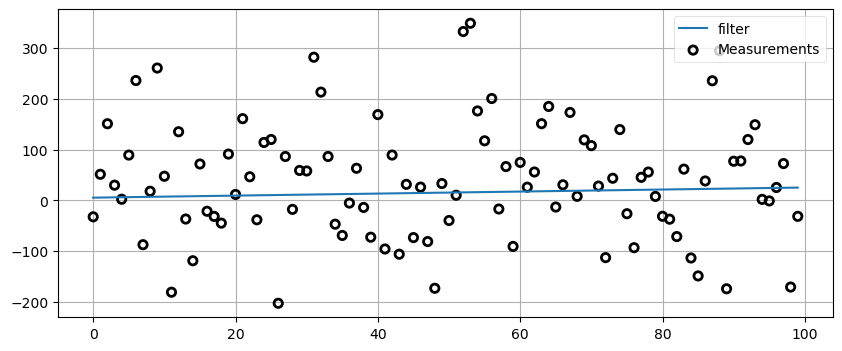

In [104]:
zs = gen_data(x0=5., dx=.2, count=100, noise_factor=100)
data = g_h_filter(data=zs, x0=5., dx=.2, dt=1., g=0., h=0.)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

Я блестяще извлек прямую линию из очень зашумленных данных! Может быть, мне пока не стоит пытаться получить свою Филдсовскую медаль по математике. Я сделал это, установив для $g$ и $h$ значения 0. Что это делает? Это заставляет фильтр игнорировать измерения, и поэтому для каждого обновления он вычисляет новую позицию как $x + \Delta x \Delta t $. Конечно, результатом будет прямая линия, если мы проигнорируем измерения. 

Фильтр, который игнорирует измерения, бесполезен. Я знаю, что вы никогда бы не установили оба значения $ g $ и $ h $ равными нулю, поскольку для этого требуется особый вид гения, которым обладаю только я, но я обещаю, что если вы не будете осторожны, вы установите их ниже, чем они должны быть. Вы всегда можете получить отличные результаты на основе тестовых данных. Когда вы попробуете свой фильтр на разных данных, вы будете разочарованы результатами, потому что вы точно настроили константы для определенного набора данных. $g$ и $h$ должны отражать реальное поведение системы, которую вы фильтруете, а не поведение одного конкретного набора данных. В последующих главах мы узнаем много нового о том, как это сделать. На данный момент я могу только сказать, будьте осторожны, или вы получите идеальные результаты с вашими тестовыми данными, но результаты, подобные этим, как только вы переключитесь на реальные данные:

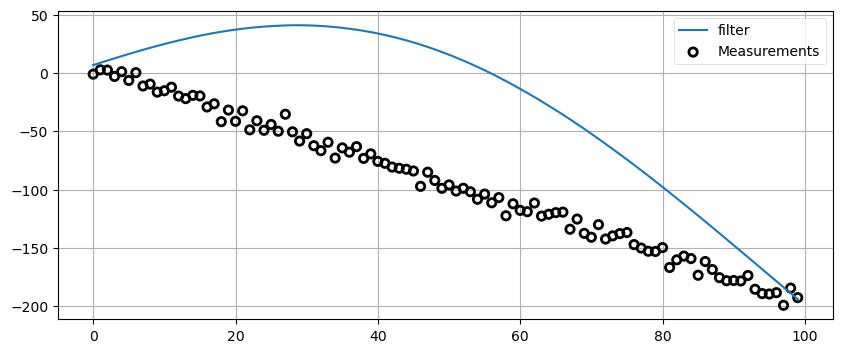

In [105]:
zs = gen_data(x0=5, dx=-2, count=100, noise_factor=5)
data = g_h_filter(data=zs, x0=5., dx=2., dt=1., g=.005, h=0.001)
book_plots.plot_measurements(zs)
book_plots.plot_filter(data, label='filter')
plt.legend(loc=1);

## Слежение за поездом

Мы готовы к практическому примеру. Ранее в этой главе мы говорили о слежении за поездом. Поезда тяжелые и медленные, поэтому они не могут быстро менять скорость. Они находятся на трассе, поэтому они не могут изменить направление, кроме как замедлиться до остановки, а затем изменить курс. Следовательно, мы можем сделать вывод, что если мы уже знаем приблизительное местоположение и скорость поезда, то мы можем с большой точностью предсказать его местоположение в ближайшем будущем. Поезд не может сильно изменить свою скорость за секунду или две. 

Итак, давайте напишем фильтр для поезда. Его положение выражается как его положение на пути относительно некоторой фиксированной точки, которая, как мы говорим, равна 0 км. Т.е. положение 1 означает, что поезд находится на расстоянии 1 км от фиксированной точки. Скорость выражается в метрах в секунду. Мы выполняем измерение положения один раз в секунду, и погрешность составляет $\pm$ 500 метров. Как мы должны реализовать наш фильтр?

Во-первых, давайте смоделируем ситуацию без фильтра. Мы предположим, что поезд в настоящее время находится на 23 километре и движется со скоростью 15 м/с. Мы можем запрогать это как 

```python
pos = 23*1000
vel = 15
```

Теперь мы можем вычислить положение поезда в какое-то будущее время, *предполагая* отсутствие изменения скорости, с

```python
def compute_new_position(pos, vel, dt=1):
    return pos + (vel * dt)
```

Мы можем смоделировать измерение, добавив к положению некоторый случайный шум. Здесь наша ошибка составляет 500m, поэтому код может выглядеть следующим образом:

```python
def measure_position(pos):
        return pos + random.randn()*500
```
        
Давайте поместим это в ячейку и построим график результатов 100 секунд моделирования. Я буду использовать функцию Numpy `asarray` для преобразования данных в массив NumPy. Это позволит мне разделить все элементы массива сразу с помощью оператора '/'.

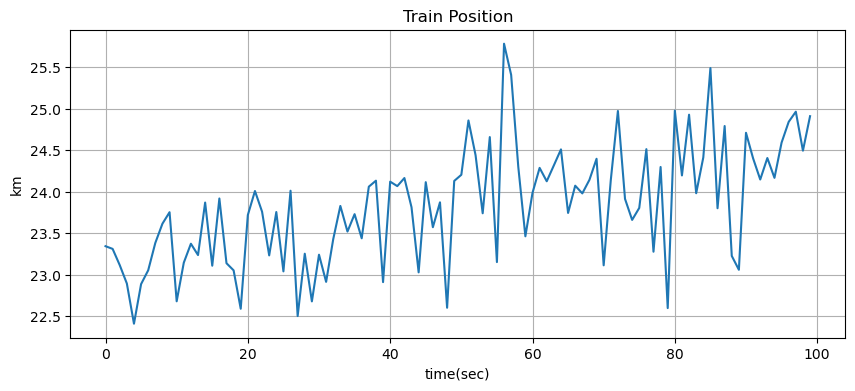

In [106]:
from numpy.random import randn

def compute_new_position(pos, vel, dt=1.):
    """ dt is the time delta in seconds."""
    return pos + (vel * dt)

def measure_position(pos):
    return pos + randn()*500

def gen_train_data(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        zs.append(measure_position(pos))
    return np.asarray(zs)
  
pos, vel = 23.*1000, 15.
zs = gen_train_data(pos, vel, 100)

plt.plot(zs / 1000.)  # convert to km
book_plots.set_labels('Train Position', 'time(sec)', 'km')

Из диаграммы видно, насколько плохи результаты измерений. Ни один настоящий поезд никогда не смог бы так двигаться. 

Итак, что мы должны установить в $g$ и $h$, если мы хотим отфильтровать эти данные? Мы не разработали теорию для этого, но давайте попробуем получить разумный ответ на месте наших штанов. Мы знаем, что измерения очень неточны, поэтому мы вообще не хотим придавать им большого значения. Для этого нам нужно выбрать очень маленький $g$. Мы также знаем, что поезда не могут быстро ускоряться или замедляться, поэтому нам также нужен очень маленький $h$. Например:

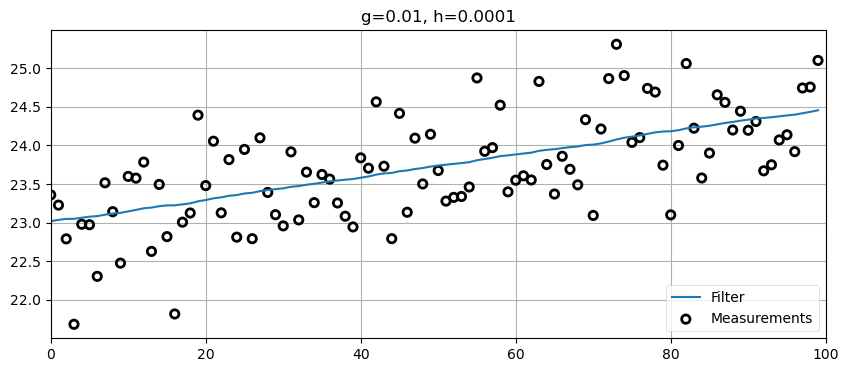

In [107]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

Это довольно хорошо для первоначального предположения. Давайте увеличим $ g$, чтобы увидеть эффект.

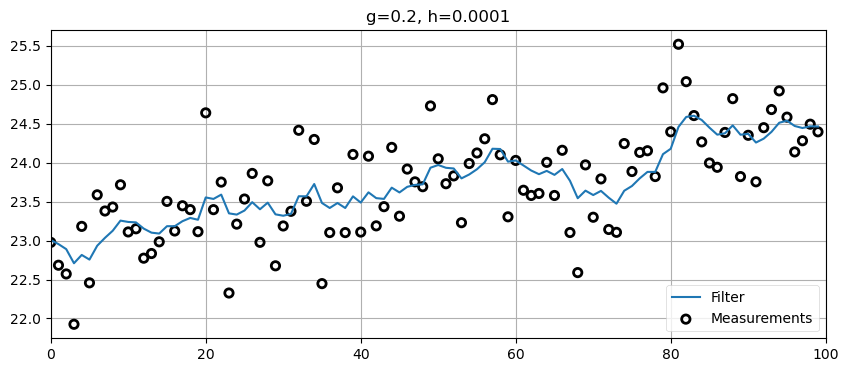

In [108]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.2, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.2, h=0.0001')

Мы сделали `g = 0,2`, и мы можем видеть, что, хотя положение поезда сглажено, предполагаемое положение (и, следовательно, скорость) сильно колеблется в очень крошечном кадре, гораздо больше, чем может сделать настоящий поезд. Итак, эмпирически мы знаем, что нам нужно `g<<0.2`.

Теперь давайте посмотрим на эффект плохого выбора для $h$.

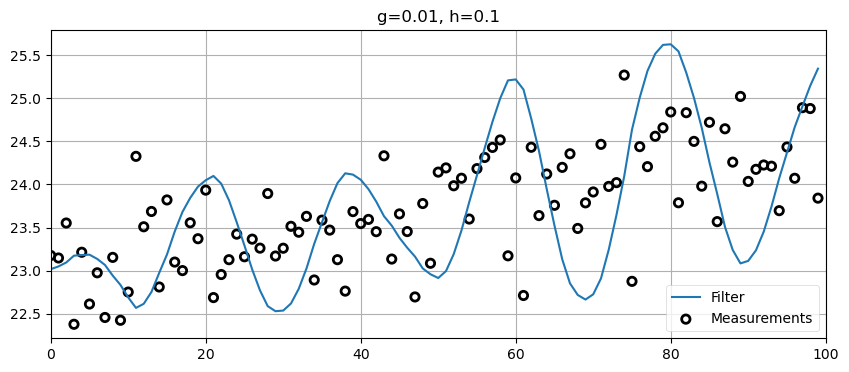

In [109]:
zs = gen_train_data(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=0.01, h=0.1)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.1')

Здесь положение плавно меняется благодаря небольшому значению $g$, но большое значение $h$ делает фильтр очень чувствительным к измерениям. Это происходит потому, что в течение нескольких секунд быстро меняющееся измерение подразумевает очень большое изменение скорости, и большой $ h $ говорит фильтру быстро реагировать на эти изменения. Поезда не могут быстро менять скорость, поэтому фильтр плохо справляется с фильтрацией данных - фильтр меняет скорость быстрее, чем это может сделать поезд.

Наконец, давайте добавим немного ускорения поезду. Я не знаю, как быстро на самом деле может разогнаться поезд, но предположим, что он ускоряется со скоростью 0,2 м / сек ^ 2. 

In [110]:
def gen_train_data_with_acc(pos, vel, count):
    zs = []
    for t in range(count):
        pos = compute_new_position(pos, vel)
        vel += 0.2
        zs.append(measure_position(pos))
    return np.asarray(zs) 

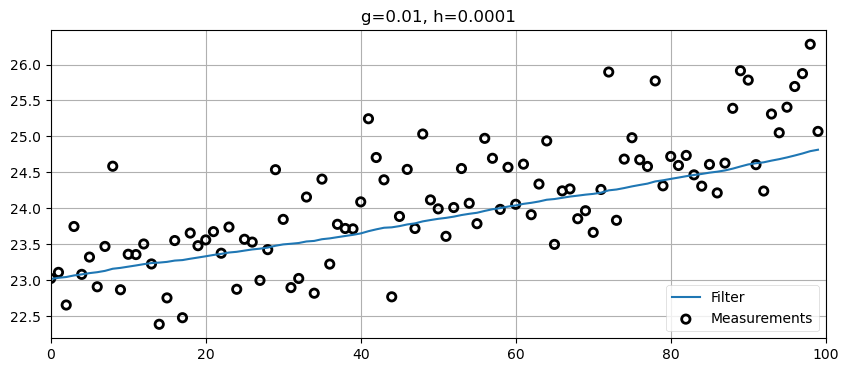

In [111]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.0001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.0001')

Здесь мы видим, что фильтр больше не отслеживает поезд из-за ускорения. Мы можем поиграть с $ h $, чтобы он лучше отслеживался, за счет менее плавной отфильтрованной оценки.

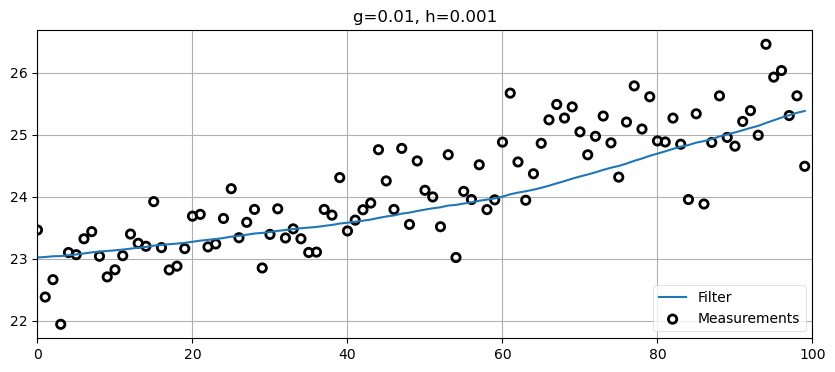

In [114]:
zs = gen_train_data_with_acc(pos=pos, vel=15., count=100)
data = g_h_filter(data=zs, x0=pos, dx=15., dt=1., g=.01, h=0.001)
plot_g_h_results(zs/1000., data/1000., 'g=0.01, h=0.001')

Здесь следует извлечь два урока. Во-первых, используйте термин $ h$ для реагирования на изменения скорости, которые вы не моделируете. Но, что гораздо важнее, здесь есть компромисс между быстрым и точным реагированием на изменения в поведении и получением идеального результата, когда система находится в устойчивом состоянии, которое у вас есть. Если поезд никогда не меняет скорость, мы бы сделали $ h $ чрезвычайно малым, чтобы избежать чрезмерного влияния шума при измерении на отфильтрованную оценку. Но в интересной задаче почти всегда происходят изменения состояния, и мы хотим быстро реагировать на них. Чем быстрее мы реагируем на них, тем больше на нас влияет шум в датчиках. 

Я мог бы продолжать, но моя цель состоит не в том, чтобы развивать здесь теорию фильтров g-h, а в том, чтобы получить представление о том, как объединение измерений и прогнозов приводит к отфильтрованному решению. Существует обширная литература по выбору $ g $ и $ h $ для таких задач, как эта, и существуют оптимальные способы их выбора для достижения различных целей. Как я объяснял ранее, легко "солгать" фильтру, экспериментируя с тестовыми данными, подобными этому. В последующих главах мы узнаем, как фильтр Калмана решает эту проблему тем же базовым способом, но с гораздо более сложной математикой. 

## g-h фильтры с FilterPy

[FilterPy](https://github.com/rlabbe/filterpy) - это библиотека фильтрации с открытым исходным кодом, которую я написал. В нем есть все фильтры, описанные в этой книге, а также другие. Довольно легко запрограммировать свой собственный фильтр g-h, но по мере продвижения мы будем больше полагаться на FilterPy. В качестве краткого введения давайте рассмотрим фильтр g-h в FilterPy.

Если у вас не установлен фильтр, просто выполните следующую команду из командной строки.

    pip install filterpy
    
Прочтите Приложение A для получения дополнительной информации об установке или загрузке Filter Py с GitHub.

Чтобы использовать фильтр g-h, импортируйте его и создайте объект из класса `GHFilter`.

In [115]:
from filterpy.gh import GHFilter
f = GHFilter(x=0., dx=0., dt=1., g=.8, h=.2)

Когда вы создаете объект, вы указываете начальное значение и скорость изменения сигнала (`x` и `dx`), временной шаг между обновлениями (`dt`) и два параметра фильтра (`g` и `h`). "dx" должно иметь те же единицы измерения, что и `x`/`dt` - если `x` выражено в метрах, а `dt` - в секундах, то `dx` должно быть в метрах в секунду.

Чтобы запустить обновление вызова фильтра, передайте измерение в параметре `z`, который, как вы помните, является стандартным названием для измерений в литературе.

In [48]:
f.update(z=1.2)

(0.96, 0.24)

`update()` returns the new value of `x` and `dx` in a tuple, but you can also access them from the object.

In [49]:
print(f.x, f.dx)

0.96 0.24


You can dynamically alter `g` and `h`.

In [50]:
print(f.update(z=2.1, g=.85, h=.15))

(1.965, 0.375)


You can filter a sequence of measurements in a batch.

In [51]:
print(f.batch_filter([3., 4., 5.]))

[[1.965 0.375]
 [2.868 0.507]
 [3.875 0.632]
 [4.901 0.731]]


You can filter multiple independent variables. If you are tracking an aircraft you'll need to track it in 3D space. Use NumPy arrays for `x`, `dx`, and the measurements.

In [52]:
x_0  = np.array([1., 10., 100.])
dx_0 = np.array([10., 12., .2])
               
f_air = GHFilter(x=x_0, dx=dx_0, dt=1., g=.8, h=.2)
f_air.update(z=np.array((2., 11., 102.)))
print(' x =', f_air.x)
print('dx =', f_air.dx)

 x = [  3.8   13.2  101.64]
dx = [8.2  9.8  0.56]


The class `GHFilterOrder` allows you to create a filter of order 0, 1, or 2. A g-h filter is order 1. The g-h-k filter, which we haven't talked about, also tracks accelerations. Both classes have functionality required by real applications, such as computing the Variance Reduction Factor (VRF), which we haven't discussed in this chapter. I could fill a book just on the theory and applications of g-h filters, but we have other goals in this book. If you are interested, explore the FilterPy code and do some further reading.

The documentation for FilterPy is at https://filterpy.readthedocs.org/.

## Итоги

Я призываю вас поэкспериментировать с этим фильтром, чтобы лучше понять, как он реагирует. Не должно потребоваться слишком много попыток, чтобы прийти к осознанию того, что специальные варианты для $g$ и $h$ работают не очень хорошо. Конкретный выбор может хорошо сработать в одной ситуации, но очень плохо - в другой. Даже когда вы понимаете влияние $g$ и $h$, может быть трудно выбрать правильные значения. На самом деле, крайне маловероятно, что вы выберете значения для $g$ и $h$, которые являются оптимальными для любой данной задачи. Фильтры *разработаны*, а не выбраны *ad hoc*.

В некотором смысле я не хочу заканчивать здесь главу, поскольку мы можем многое сказать о выборе $g$ и $h$. Но фильтр g-h в этой форме не является целью этой книги. Проектирование фильтра Калмана требует от вас указания ряда параметров - косвенно они связаны с выбором $g$ и $h$, но вы никогда не будете ссылаться на них напрямую при проектировании фильтров Калмана. Кроме того, $g$ и $h$ будут меняться на каждом временном шаге очень неочевидным образом.

Есть еще одна особенность этих фильтров, которую мы едва затронули, - байесовская статистика. Вы заметите, что термин "байесовский" присутствует в названии этой книги; это не совпадение! На данный момент мы оставим $g$ и $h$ позади, в значительной степени неисследованными, и разработаем очень мощную форму вероятностных рассуждений о фильтрации. И все же внезапно появится тот же алгоритм фильтрации g-h, на этот раз с формальным математическим построением, которое позволяет нам создавать фильтры из нескольких датчиков, точно оценивать количество ошибок в нашем решении и управлять роботами.